In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math

def psy_analytic(x, lamb = -1, case = 1):
    '''
        psy_analytic = np.exp(lamb*x)
    '''
    if case == 1:
        return tf.exp(lamb*x)
    elif case == 2:
        return tf.sin(x)
    elif case == 3:
        return -1 / (1 + x)

def f(x, psy, case = 1):
    if case == 1:
        '''
            d(psy)/dx = f(x, psy)
            y' = B(x) - A(x) * y
        '''
        def A(x, case = 1):
            if case == 1:
                return 1

        def B(x, case = 1):
            if case == 1:
                return 0

        return B(x) - A(x)*psy
    
    elif case == 2:
        '''
            Prothero Robinson
            y' 
        '''
        return -1000*(psy - tf.sin(x)) + tf.cos(x)

    elif case == 3:
        return psy**2

def y(x, w, case = 1): 
    '''
        y(x) = bias + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    if case == 1:
        bias = 1.
    elif case == 2:
        bias = 0.
    elif case == 3:
        bias = -1.

    y = bias
    w_v = w.variables[0]
    n = w_v.shape[0]
    for i in range(1, n+1):
        y += w_v[i-1]*x**i
    
    return y

def y_hamiltonian(x, w): 
    '''
        y1(x) = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
        y2(x) = w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    y1 = 1
    w_1 = w.v[0]
    n = w_1.shape[0]
    for i in range(1, n+1):
        y1 += w_1[i-1]*x**i
    
    y2 = 0
    w_2 = w.v[1]
    n = w_2.shape[0]
    for i in range(1, n+1):
        y2 += w_2[i-1]*x**i

    return y1, y2

def y_hamiltonian_EC(x, w, NN, bias):
    '''
        y1(x) = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n) + y1_NN(x)*x
        y2(x) = w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n) + y2_NN(x)*x
    '''
    y = bias
    w = w.v[0]
    n = w.shape[0]
    for i in range(1, n+1):
        y += w[i-1]*x**i

    return y + NN(x)*x

def y_loss(x, w, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형
    
    with tf.GradientTape() as tape:
        tape.watch(x)

        _y = y(x, w, case = case)
        d_y = tape.gradient(_y, x)
    
    _loss = d_y - f(x, _y, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def y_EC_loss(x, w, NN, case = 1):
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    with tf.GradientTape() as tape:
        tape.watch(x)

        y_EC = tf.add(y(x, w, case), NN(x)*x)
        d_y_EC = tape.gradient(y_EC, x)

    _loss = d_y_EC - f(x, y_EC, case)
    square_loss = tf.square(_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def PINN(x, NN, case = 1):
    x = x.reshape(-1, 1)
    x = tf.constant(x, dtype = tf.float32)
    x_0 = tf.zeros((1, 1))
    if case == 1:
        one = tf.ones((1, 1))
    elif case == 2:
        one = tf.zeros((1, 1))
    elif case == 3:
        one = -1*tf.ones((1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x)

        PINN_NN = NN(x)
        d_PINN_NN = tape.gradient(PINN_NN, x)

    _loss = d_PINN_NN - f(x, PINN_NN, case)
    IC_loss = NN(x_0) - one
    square_loss = tf.square(_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss


def train(train_x, n, case):
    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(n, ), dtype=tf.float32))

    NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    print('start y')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_loss(train_x, w, case)

            grad_w = tape.gradient(train_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))

    print('start y + EC')
    for itr in range(3000):
        with tf.GradientTape() as tape:
            train_loss = y_EC_loss(train_x, w, NN, case)

            grad_NN = tape.gradient(train_loss, NN.trainable_variables)
            optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss : {}'.format(itr, train_loss.numpy()))
    
    return w, NN

def result_pred(train_x, case, w, NN):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형

    pred_y = y(test_x, w, case)
    NN_pred_y = tf.add(y(test_x, w, case), NN.predict(test_x)*test_x)

    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, case = case)
    true_y = psy_analytic(test_x, case = case)

    return pred_y, NN_pred_y, train_y, true_y

def graph_show(train_x, train_y, true_y, pred_y, NN_pred_y):
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)
    ax.plot(train_x, train_y, 'ob', label = 'Train')
    ax.plot(test_x, true_y, '-k', label = 'True')
    ax.plot(test_x, pred_y, '--r', label = 'Prediction')
    ax.plot(test_x, NN_pred_y, '--g', label = 'NN_Prediction')
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=20)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    plt.plot(test_x, tf.abs(np.array(pred_y).flatten() - true_y), '-r', label = 'Error')
    plt.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-g', label = 'NN_Error')
    ax2.tick_params(labelsize=10)
    ax2.legend(fontsize=20)
    ax2.grid()

def result_1(Epoch, case = 1):
    '''
        result 1

        w 개수별
        polynomial Graph
        1. Exact
        2. 1st
        3. 2ed
        4. 3rd

        learning_rate = 1e-3
        train_x = 0 ~ 1 사이 20개 균등 배열
        충분히 학습 될 때 까지, Epoch 10000
        Pn(x)로도 충분히 잘 근사 한다.
    '''
    w_1 = tf.Module()
    w_1.v = tf.Variable(tf.random.normal(shape=(1, ), dtype=tf.float32))

    w_2 = tf.Module()
    w_2.v = tf.Variable(tf.random.normal(shape=(2, ), dtype=tf.float32))

    w_3 = tf.Module()
    w_3.v = tf.Variable(tf.random.normal(shape=(3, ), dtype=tf.float32))

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    train_x = np.array([i/20 for i in range(20)]).reshape((-1, 1))

    print('start y')
    for itr in range(Epoch):
        with tf.GradientTape() as tape:
            train_loss_1 = y_loss(train_x, w_1, case = case)
            grad_w_1 = tape.gradient(train_loss_1, w_1.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_1, w_1.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_2 = y_loss(train_x, w_2, case = case)
            grad_w_2 = tape.gradient(train_loss_2, w_2.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_2, w_2.trainable_variables))

        with tf.GradientTape() as tape:
            train_loss_3 = y_loss(train_x, w_3, case = case)
            grad_w_3 = tape.gradient(train_loss_3, w_3.trainable_variables)
            optimizer.apply_gradients(zip(grad_w_3, w_3.trainable_variables))

        if itr % 1000 == 0:
            print('iter : {}, loss_1 : {}'.format(itr, train_loss_1.numpy()))
            print('iter : {}, loss_2 : {}'.format(itr, train_loss_2.numpy()))
            print('iter : {}, loss_3 : {}'.format(itr, train_loss_3.numpy()))

    # show_graph
    test_x = np.linspace(0, 1, 100)
    train_y = psy_analytic(train_x, lamb = -1, case = case)
    true_y = psy_analytic(test_x, lamb = -1, case = case)
    test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
    test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
    pred_y_1 = y(test_x, w_1, case = case)
    pred_y_2 = y(test_x, w_2, case = case)
    pred_y_3 = y(test_x, w_3, case = case)

    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(121)

    ax.plot(train_x, train_y, 'ob', label = 'Train')
    ax.plot(test_x, true_y, '-k', label = 'Exact')
    ax.plot(test_x, pred_y_1, '--r', label = '1st')
    ax.plot(test_x, pred_y_2, '--b', label = '2ed')
    ax.plot(test_x, pred_y_3, '--g', label = '3rd')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    ax.set_title('y', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=15)
    ax.grid()
    # Error
    ax2 = fig.add_subplot(122)
    ax2.plot(test_x, tf.abs(np.array(pred_y_1).flatten() - true_y), '-r', label = '1st Error')
    ax2.plot(test_x, tf.abs(np.array(pred_y_2).flatten() - true_y), '-b', label = '2ed Error')
    ax2.plot(test_x, tf.abs(np.array(pred_y_3).flatten() - true_y), '-g', label = '3rd Error')
    ax2.set_xlabel('x', fontsize=15)
    ax2.set_ylabel('Error', fontsize=15)
    ax2.set_title('Error', fontsize=15)
    ax2.tick_params(labelsize=10)
    ax2.legend( fontsize=15)
    ax2.grid()

def result_2(Epoch, case = 1):
    '''
        result 2

        Error
        Poly + EC vs PINN

        setting
        learning_rate = 1e-3
        train_x : 0 ~ 1 사이 20개 (균등 분배)
        layer 개수 : 4개
        weight : 32, 64, 64, 32
        optimizer function : tanh

        Poly weight 개수 : 3개
        Poly Epoch : 10,000

        Poly + EC, PINN Epoch : 1000, 10000
    '''
    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(3, ), dtype=tf.float32))

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    train_x = np.array([i/20 for i in range(20)]).reshape((-1, 1))

    print('start y')
    for itr in range(1, 10001):
        with tf.GradientTape() as tape:
            train_loss = y_loss(train_x, w, case = case)

            grad_w = tape.gradient(train_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, y_loss : {}'.format(itr, train_loss.numpy()))
    
    count = 1
    print('start y + EC and PINN')
    while True:
        print('count :', count)
        NN = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])

        PINN_NN = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])
        
        for itr in range(1, Epoch+1):
            with tf.GradientTape() as tape:
                train_loss_NN = y_EC_loss(train_x, w, NN, case = case)
                grad_NN = tape.gradient(train_loss_NN, NN.trainable_variables)
                optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))
            
            with tf.GradientTape() as tape:
                train_loss_PINN = PINN(train_x, PINN_NN, case = case)
                grad_PINN_NN = tape.gradient(train_loss_PINN, PINN_NN.trainable_variables)
                optimizer.apply_gradients(zip(grad_PINN_NN, PINN_NN.trainable_variables))

            if itr % 5000 == 0:
                print('iter : {}, yEC_loss : {}'.format(itr, train_loss_NN.numpy()))
                print('iter : {}, PINN_loss : {}'.format(itr, train_loss_PINN.numpy()))
        
        test_x = np.linspace(0, 1, 100)
        true_y = psy_analytic(test_x, lamb = -1, case = case)
        test_x = np.linspace(0, 1, 100).reshape(-1, 1)    # (x크기, 1)
        test_x = tf.constant(test_x, dtype = tf.float32)  # tensor 상수로 변형
        NN_pred_y = tf.add(y(test_x, w, case = case), NN.predict(test_x)*test_x)
        PINN_pred_y = PINN_NN.predict(test_x)

        if tf.reduce_sum(tf.abs(np.array(NN_pred_y).flatten() - true_y)) <= tf.reduce_sum(tf.abs(np.array(PINN_pred_y).flatten() - true_y)): break
        count += 1
        
    # show_graph
    fig = plt.figure(figsize=(18,5))

    # Error
    ax = fig.add_subplot(122)
    ax.plot(test_x, tf.abs(np.array(NN_pred_y).flatten() - true_y), '-r', label = 'y + EC')
    ax.plot(test_x, tf.abs(np.array(PINN_pred_y).flatten() - true_y), '-g', label = 'PINN')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('Error', fontsize=15)
    ax.set_title('Error', fontsize=15)
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=15)
    ax.grid()

In [9]:
def hamiltonian_w(n):
    y_n = 2

    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(y_n, n), dtype=tf.float32))

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    train_x = np.linspace(0, 2*math.pi, 20).reshape((-1, 1))
    train_x = train_x.reshape(-1, 1)    # (train_x크기, 1)
    train_x = tf.constant(train_x, dtype = tf.float32)  # tensor 상수로 변형

    print('Start hamiltonian : {}차'.format(n))
    save_loss = 0
    for itr in range(10001):
        with tf.GradientTape() as tape_loss:
            tape_loss.watch(train_x)
            
            with tf.GradientTape() as tape_y1:
                tape_y1.watch(train_x)

                y1, y2 = y_hamiltonian(train_x, w)
                d_y1 = tape_y1.gradient(y1, train_x)

            with tf.GradientTape() as tape_y2:
                tape_y2.watch(train_x)

                y1, y2 = y_hamiltonian(train_x, w)
                d_y2 = tape_y2.gradient(y2, train_x)

            loss_1 = d_y1 + y2
            loss_2 = d_y2 - y1
            y10, y20 = y_hamiltonian(tf.zeros([1, 1]), w)
            loss_3 = y10 - tf.ones([1, 1])
            loss_4 = y20 - tf.ones([1, 1])
            square_loss = tf.square(loss_1) + tf.square(loss_2) + tf.square(loss_3) + tf.square(loss_4)
            total_loss = tf.reduce_mean(square_loss)

            grad_w = tape_loss.gradient(total_loss, w.trainable_variables)
            optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, y_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss

    return w

w_1 = hamiltonian_w(1)
w_2 = hamiltonian_w(2)
w_3 = hamiltonian_w(3)

Start hamiltonian : 1차
iter : 0, y_loss : 101.54765319824219
iter : 5000, y_loss : 1.2509105205535889
iter : 10000, y_loss : 1.2506706714630127
Start hamiltonian : 2차
iter : 0, y_loss : 1151.265625
iter : 5000, y_loss : 3.3871688842773438
iter : 10000, y_loss : 1.1104156970977783
Start hamiltonian : 3차
iter : 0, y_loss : 2765.113037109375
iter : 5000, y_loss : 3.778979539871216
iter : 10000, y_loss : 1.5748708248138428


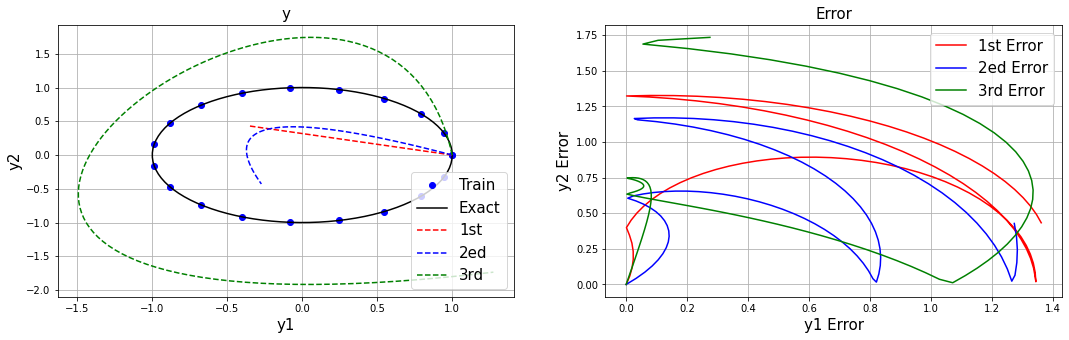

In [10]:
# show_graph
test_x = np.linspace(0, 2*np.pi, 100, dtype = 'float32')
train_x = np.linspace(0, 2*math.pi, 20).reshape((-1, 1))

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

y11, y12 = y_hamiltonian(test_x, w_1)
y21, y22 = y_hamiltonian(test_x, w_2)
y31, y32 = y_hamiltonian(test_x, w_3)

ax.plot(tf.math.cos(train_x), tf.math.sin(train_x), 'ob', label = 'Train')
ax.plot(tf.math.cos(test_x), tf.math.sin(test_x), '-k', label = 'Exact')
ax.plot(y11, y12, '--r', label = '1st')
ax.plot(y21, y22, '--b', label = '2ed')
ax.plot(y31, y32, '--g', label = '3rd')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(tf.abs(tf.math.cos(test_x) - y11), tf.abs(tf.math.sin(test_x) - y12), '-r', label = '1st Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y21), tf.abs(tf.math.sin(test_x) - y22), '-b', label = '2ed Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y31), tf.abs(tf.math.sin(test_x) - y32), '-g', label = '3rd Error')
ax2.set_xlabel('y1 Error', fontsize=15)
ax2.set_ylabel('y2 Error', fontsize=15)
ax2.set_title('Error', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()

In [11]:
def hamiltonian_EC_train(w):
    x = np.linspace(0, 2*math.pi, 20).reshape((-1, 1))
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    y1_NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    y2_NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    save_loss = 0
    for itr in range(10001):
        with tf.GradientTape() as tape:
            tape.watch(x)
            with tf.GradientTape() as tape_y1:
                tape_y1.watch(x)

                y1_EC = y_hamiltonian_EC(x, w, y1_NN, bias = 1)
                d_y1_EC = tape_y1.gradient(y1_EC, x)

            with tf.GradientTape() as tape_y2:
                tape_y2.watch(x)

                y2_EC = y_hamiltonian_EC(x, w, y2_NN, bias = 0)
                d_y2_EC = tape_y2.gradient(y2_EC, x)

            loss_1 = d_y1_EC + y2_EC
            loss_2 = d_y2_EC - y1_EC
            square_loss = tf.square(loss_1) + tf.square(loss_2)
            total_loss = tf.reduce_mean(square_loss)

            grad_y1_NN, grad_y2_NN = tape.gradient(total_loss, [y1_NN.trainable_variables, y2_NN.trainable_variables])
            optimizer.apply_gradients(zip(grad_y1_NN, y1_NN.trainable_variables))
            optimizer.apply_gradients(zip(grad_y2_NN, y2_NN.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, hamiltonian_y_total_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss
    return y1_NN, y2_NN

print('start w1 EC')
y11_NN, y12_NN = hamiltonian_EC_train(w_1)
print('start w2 EC')
y21_NN, y22_NN = hamiltonian_EC_train(w_2)
print('start w3 EC')
y31_NN, y32_NN = hamiltonian_EC_train(w_3)

start w1 EC
iter : 0, hamiltonian_y_total_loss : 0.9277122616767883
iter : 5000, hamiltonian_y_total_loss : 0.0005973797524347901
iter : 10000, hamiltonian_y_total_loss : 0.0010957710910588503
start w2 EC
iter : 0, hamiltonian_y_total_loss : 11.578869819641113
iter : 5000, hamiltonian_y_total_loss : 0.00020758183381985873
iter : 10000, hamiltonian_y_total_loss : 0.013893865048885345
start w3 EC
iter : 0, hamiltonian_y_total_loss : 21.07162094116211
iter : 5000, hamiltonian_y_total_loss : 0.003194117220118642
iter : 10000, hamiltonian_y_total_loss : 2.08076489798259e-05


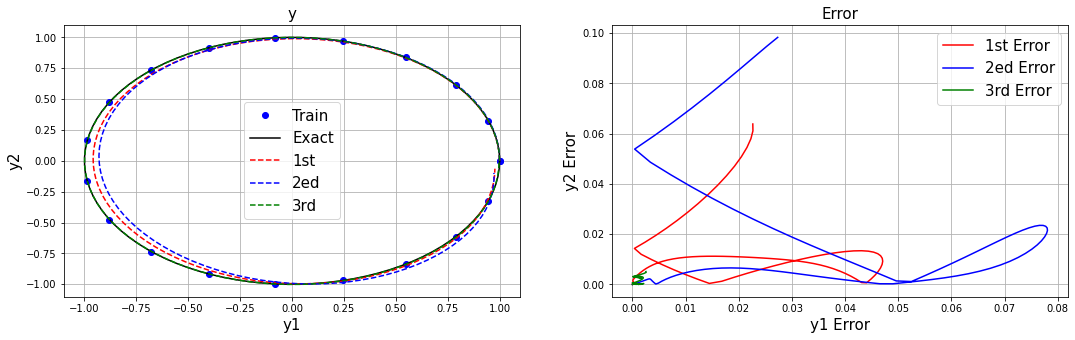

In [12]:
# show_graph
test_x = np.linspace(0, 2*np.pi, 100, dtype = 'float32').reshape(-1, 1)
train_x = np.linspace(0, 2*np.pi, 20).reshape(-1, 1)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

y11_EC, y12_EC = y_hamiltonian_EC(test_x, w_1, y11_NN, bias = 1), y_hamiltonian_EC(test_x, w_1, y12_NN, bias = 0)
y21_EC, y22_EC = y_hamiltonian_EC(test_x, w_2, y21_NN, bias = 1), y_hamiltonian_EC(test_x, w_2, y22_NN, bias = 0)
y31_EC, y32_EC = y_hamiltonian_EC(test_x, w_3, y31_NN, bias = 1), y_hamiltonian_EC(test_x, w_3, y32_NN, bias = 0)

ax.plot(tf.math.cos(train_x), tf.math.sin(train_x), 'ob', label = 'Train')
ax.plot(tf.math.cos(test_x), tf.math.sin(test_x), '-k', label = 'Exact')
ax.plot(y11_EC, y12_EC, '--r', label = '1st')
ax.plot(y21_EC, y22_EC, '--b', label = '2ed')
ax.plot(y31_EC, y32_EC, '--g', label = '3rd')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(tf.abs(tf.math.cos(test_x) - y11_EC), tf.abs(tf.math.sin(test_x) - y12_EC), '-r', label = '1st Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y21_EC), tf.abs(tf.math.sin(test_x) - y22_EC), '-b', label = '2ed Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y31_EC), tf.abs(tf.math.sin(test_x) - y32_EC), '-g', label = '3rd Error')
ax2.set_xlabel('y1 Error', fontsize=15)
ax2.set_ylabel('y2 Error', fontsize=15)
ax2.set_title('Error', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()

In [13]:
def hamiltonian_PINN_train():
    x = np.linspace(0, 2*math.pi, 20).reshape((-1, 1))
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    y1_NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    y2_NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    save_loss = 0
    for itr in range(10001):
        with tf.GradientTape() as tape:
            tape.watch(x)
            with tf.GradientTape() as tape_y1:
                tape_y1.watch(x)

                y1 = y1_NN(x)
                d_y1 = tape_y1.gradient(y1, x)

            with tf.GradientTape() as tape_y2:
                tape_y2.watch(x)

                y2 = y2_NN(x)
                d_y2 = tape_y2.gradient(y2, x)

            loss_1 = d_y1 + y2
            loss_2 = d_y2 - y1
            loss_y1_init = tf.ones([1, 1]) - y1_NN(tf.zeros([1, 1]))
            loss_y2_init = tf.zeros([1, 1]) - y2_NN(tf.zeros([1, 1]))
            square_loss = tf.square(loss_1) + tf.square(loss_2) + tf.square(loss_y1_init) + tf.square(loss_y2_init)
            total_loss = tf.reduce_mean(square_loss)

            grad_y1_NN, grad_y2_NN = tape.gradient(total_loss, [y1_NN.trainable_variables, y2_NN.trainable_variables])
            optimizer.apply_gradients(zip(grad_y1_NN, y1_NN.trainable_variables))
            optimizer.apply_gradients(zip(grad_y2_NN, y2_NN.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, hamiltonian_y_total_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss
    return y1_NN, y2_NN

print('start w1 EC')
y1_PINN, y2_PINN = hamiltonian_PINN_train()

start w1 EC
iter : 0, hamiltonian_y_total_loss : 1.7055898904800415
iter : 5000, hamiltonian_y_total_loss : 2.1375994037953205e-05
iter : 10000, hamiltonian_y_total_loss : 0.0012264139950275421


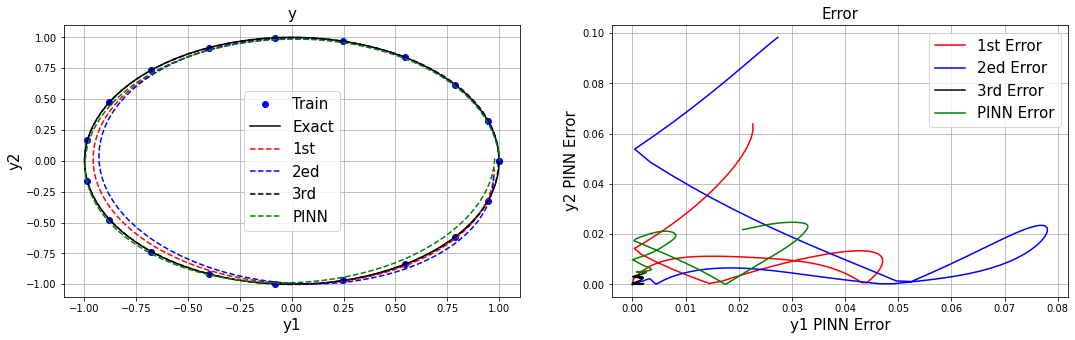

In [14]:
# show_graph
test_x = np.linspace(0, 2*np.pi, 100, dtype = 'float32').reshape(-1, 1)
train_x = np.linspace(0, 2*np.pi, 20).reshape(-1, 1)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

ax.plot(tf.math.cos(train_x), tf.math.sin(train_x), 'ob', label = 'Train')
ax.plot(tf.math.cos(test_x), tf.math.sin(test_x), '-k', label = 'Exact')
ax.plot(y11_EC, y12_EC, '--r', label = '1st')
ax.plot(y21_EC, y22_EC, '--b', label = '2ed')
ax.plot(y31_EC, y32_EC, '--k', label = '3rd')
ax.plot(y1_PINN(test_x), y2_PINN(test_x), '--g', label = 'PINN')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(tf.abs(tf.math.cos(test_x) - y11_EC), tf.abs(tf.math.sin(test_x) - y12_EC), '-r', label = '1st Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y21_EC), tf.abs(tf.math.sin(test_x) - y22_EC), '-b', label = '2ed Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y31_EC), tf.abs(tf.math.sin(test_x) - y32_EC), '-k', label = '3rd Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y1_PINN(test_x)), tf.abs(tf.math.sin(test_x) - y2_PINN(test_x)), '-g', label = 'PINN Error')
ax2.set_xlabel('y1 PINN Error', fontsize=15)
ax2.set_ylabel('y2 PINN Error', fontsize=15)
ax2.set_title('Error', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()

In [15]:
ex4_w_3 = hamiltonian_w(3)

print('start w3 EC')
ex4_y31_NN, ex4_y32_NN = hamiltonian_EC_train(ex4_w_3)

print('start PINN')
ex4_y1_PINN, ex4_y2_PINN = hamiltonian_PINN_train()

Start hamiltonian : 3차
iter : 0, y_loss : 12399.6376953125
iter : 5000, y_loss : 50.29058837890625
iter : 10000, y_loss : 3.2855918407440186
start w3 EC
iter : 0, hamiltonian_y_total_loss : 29.667072296142578
iter : 5000, hamiltonian_y_total_loss : 0.00023951797629706562
iter : 10000, hamiltonian_y_total_loss : 0.0009568530367687345
start PINN
iter : 0, hamiltonian_y_total_loss : 1.0892612934112549
iter : 5000, hamiltonian_y_total_loss : 3.924465272575617e-05
iter : 10000, hamiltonian_y_total_loss : 4.195245128357783e-05


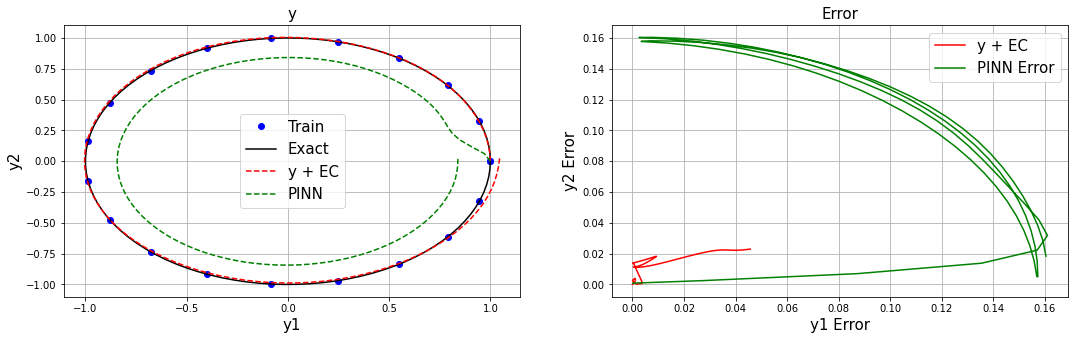

In [17]:
# show_graph
test_x = np.linspace(0, 2*np.pi, 100, dtype = 'float32').reshape(-1, 1)
train_x = np.linspace(0, 2*np.pi, 20).reshape(-1, 1)

ex4_y31_EC, ex4_y32_EC = y_hamiltonian_EC(test_x, ex4_w_3, ex4_y31_NN, bias = 1), y_hamiltonian_EC(test_x, ex4_w_3, ex4_y32_NN, bias = 0)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

ax.plot(tf.math.cos(train_x), tf.math.sin(train_x), 'ob', label = 'Train')
ax.plot(tf.math.cos(test_x), tf.math.sin(test_x), '-k', label = 'Exact')
ax.plot(ex4_y31_EC, ex4_y32_EC, '--r', label = 'y + EC')
ax.plot(ex4_y1_PINN(test_x), ex4_y2_PINN(test_x), '--g', label = 'PINN')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(tf.abs(tf.math.cos(test_x) - ex4_y31_EC), tf.abs(tf.math.sin(test_x) - ex4_y32_EC), '-r', label = 'y + EC')
ax2.plot(tf.abs(tf.math.cos(test_x) - ex4_y1_PINN(test_x)), tf.abs(tf.math.sin(test_x) - ex4_y2_PINN(test_x)), '-g', label = 'PINN Error')
ax2.set_xlabel('y1 Error', fontsize=15)
ax2.set_ylabel('y2 Error', fontsize=15)
ax2.set_title('Error', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()